In [1]:
#import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
df =pd.read_csv("/kaggle/input/smsdata/train.csv")
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


**Split data using 80:20 ratio**

In [4]:
# Separate majority and minority classes
majority_class = df[df['label'] == 0]
minority_class = df[df['label'] == 1]

# Oversample the minority class to match the majority class
minority_upsampled = resample(minority_class, 
                              replace=True,  # Sample with replacement
                              n_samples=4827,  # Target number of samples
                              random_state=42)  # For reproducibility

# Combine majority class with upsampled minority class
balanced_df = pd.concat([majority_class, minority_upsampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['sms'].tolist(), balanced_df['label'].tolist(), test_size=0.2, random_state=42
)

**Tokenization with BERT**

In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer

In [6]:

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize training and validation data **without return_tensors="tf"**
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert inputs to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.constant(val) for key, val in train_encodings.items()},
    tf.constant(train_labels)
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {key: tf.constant(val) for key, val in val_encodings.items()},
    tf.constant(val_labels)
)).batch(16)

**Load Pretrained BERT Model**

In [7]:
# Load BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Use standard Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Compile the model
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train Model**

In [8]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
483/483 [==============================] - 175s 284ms/step - loss: 0.0581 - accuracy: 0.9817 - val_loss: 0.0056 - val_accuracy: 0.9990
Epoch 2/5
483/483 [==============================] - 135s 279ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 9.2374e-04 - val_accuracy: 1.0000
Epoch 3/5
483/483 [==============================] - 134s 278ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.0148 - val_accuracy: 0.9964
Epoch 4/5
483/483 [==============================] - 134s 278ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 5/5
483/483 [==============================] - 134s 278ms/step - loss: 9.9693e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9995


**Evaluate the Model**

In [10]:
preds = model.predict(val_dataset).logits
pred_labels = tf.argmax(preds, axis=1).numpy()

print("Accuracy:", accuracy_score(val_labels, pred_labels))
print(classification_report(val_labels, pred_labels))

121/121 [==============================] - 11s 93ms/step
Accuracy: 0.9994821336095288
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       977

    accuracy                           1.00      1931
   macro avg       1.00      1.00      1.00      1931
weighted avg       1.00      1.00      1.00      1931



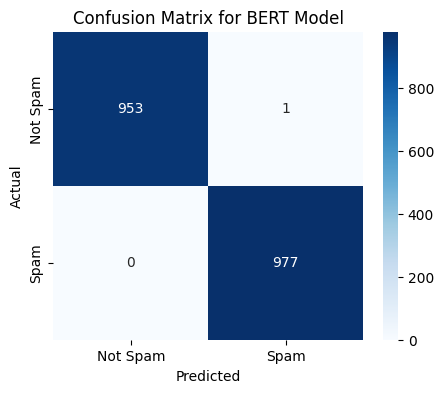

In [11]:
cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for BERT Model")
plt.show()

In [12]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Dense

In [13]:
# Tokenization
max_words = 5000  # Vocabulary size
max_len = 128     # Max length of a comment
tokenizer = Tokenizer(num_words=max_words, oov_token="")
tokenizer.fit_on_texts(balanced_df['sms'])
sequences = tokenizer.texts_to_sequences(balanced_df['sms'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, balanced_df['label'], test_size=0.2, random_state=42)

In [14]:
model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    Bidirectional(LSTM(units=128, return_sequences=False)),
                    Dense(1, activation='sigmoid')])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_len))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 128, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 734,753 (2.80 MB)

 Trainable params: 734,753 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20, batch_size = 128)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 3.4063e-05 - val_accuracy: 0.9979 - val_loss: 0.0143
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 3.7532e-05 - val_accuracy: 0.9979 - val_loss: 0.0143
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 3.5078e-05 - val_accuracy: 0.9979 - val_loss: 0.0143
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 3.5133e-05 - val_accuracy: 0.9974 - val_loss: 0.0145
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 2.8641e-05 - val_accuracy: 0.9974 - val_loss: 0.0145
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 2.2437e-05 - val_accuracy: 0.9974 - val_loss: 0.0151
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 1.8747e-05 - val_accuracy: 0.9974 - val_loss: 0.0152
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 1.866

In [17]:
import numpy as np

In [18]:
y_pred_bi_lstm = model.predict(X_test)
y_pred_bi_lstm  = np.where(y_pred_bi_lstm  > 0.5, 1, 0)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


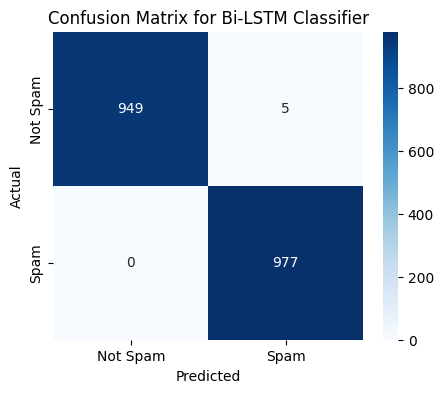

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       954
           1       0.99      1.00      1.00       977

    accuracy                           1.00      1931
   macro avg       1.00      1.00      1.00      1931
weighted avg       1.00      1.00      1.00      1931



In [19]:
cm = confusion_matrix(y_test, y_pred_bi_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Bi-LSTM Classifier")
plt.show()
print(classification_report(y_test, y_pred_bi_lstm))